# Imports

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,LSTM,GRU
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Reading the Input Data

In [3]:
path = 'D:/1buatTA/mitbih_database/mitbih_database/'  
#input path
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

##Reading files

In [4]:
# Readint input files
filenames = next(os.walk(path))[2]

# Splitting the csv files and annotation files
records = list()
annotations = list()
filenames.sort()

#Seperating files and annotations

In [5]:
# grouping csv and annotation files
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [6]:
print(len(records))

48


# Data Denoising

In [7]:
def denoise(data): 
    w = pywt.Wavelet('sym4') #syn4 - 4 max level decomposition
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) #max useful decomposition
    threshold = 0.04 # filtering threshold

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev) #adding coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4') #waverec
    
    return datarec

#Reading R positions and Arrhythmia class

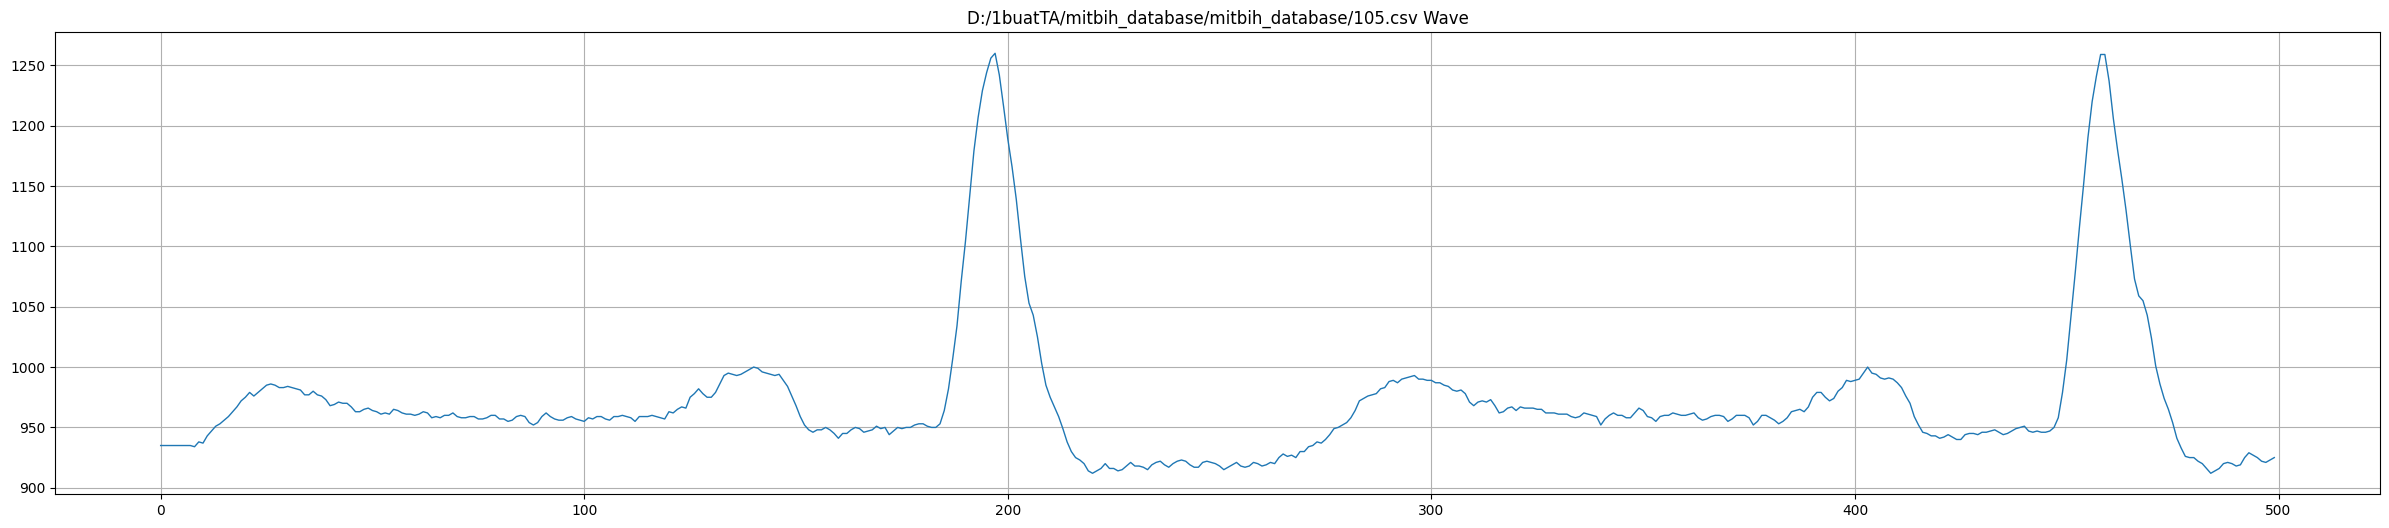

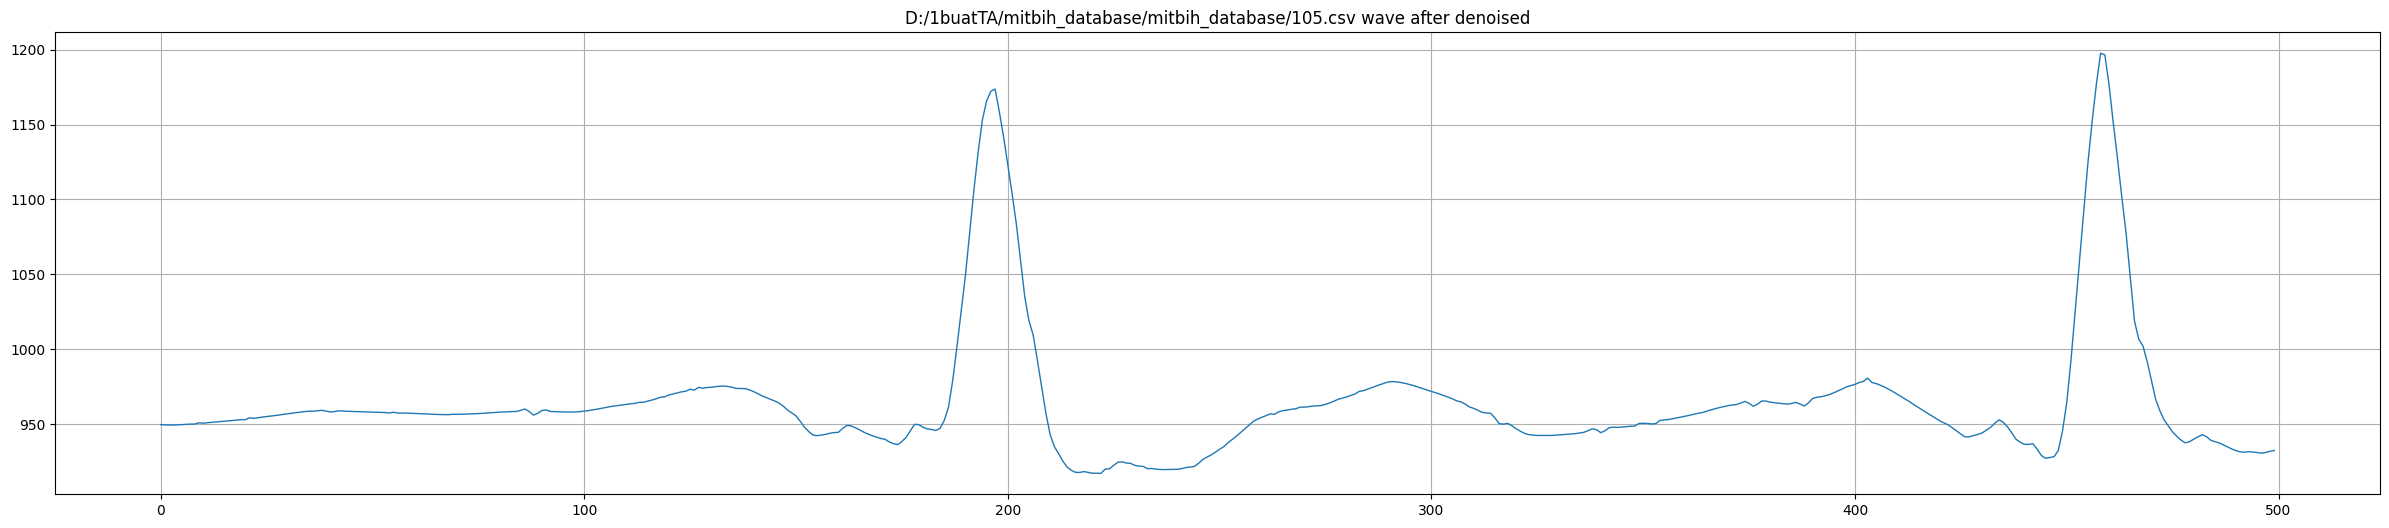

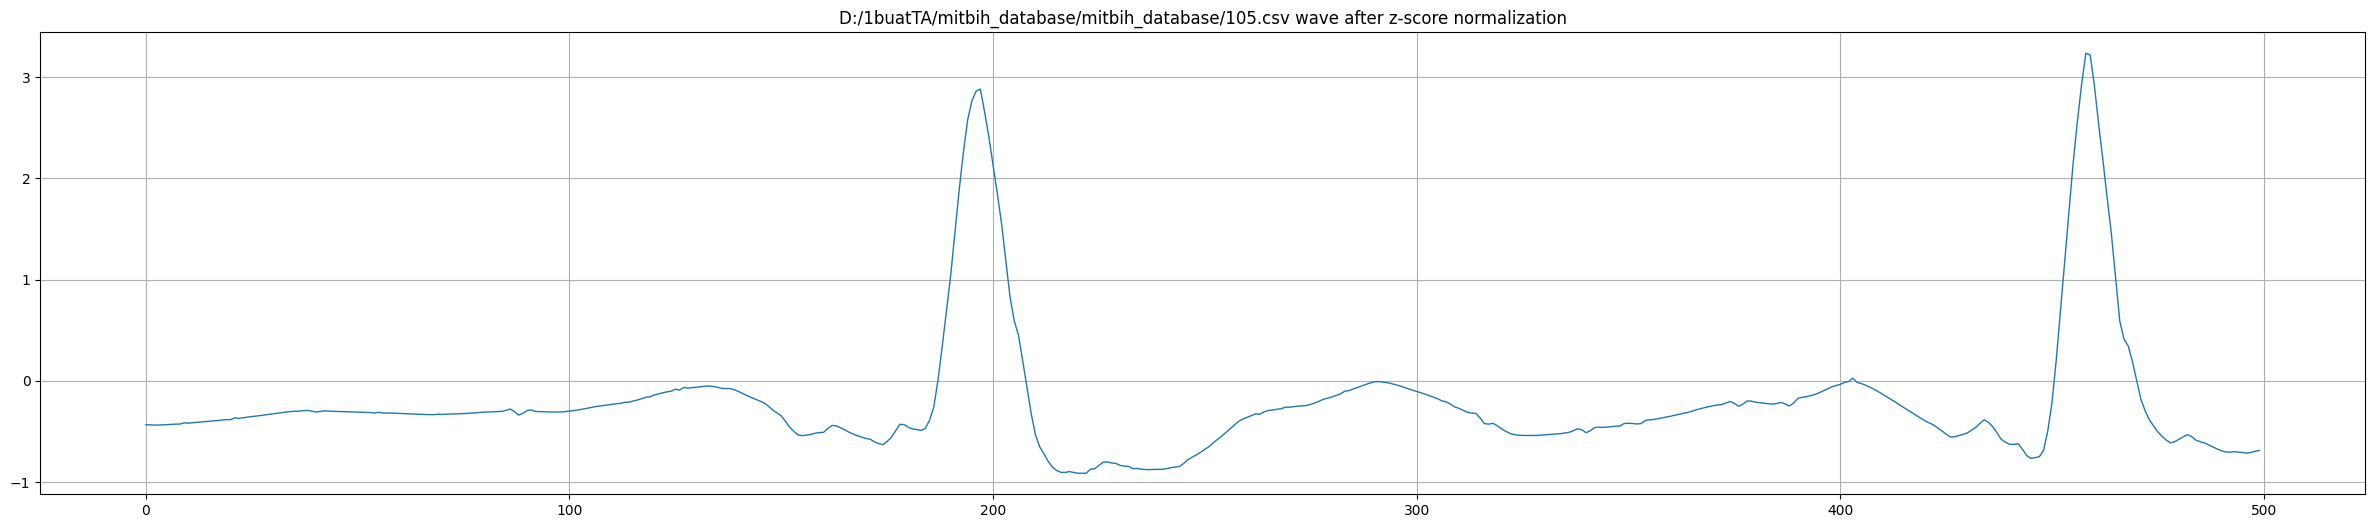

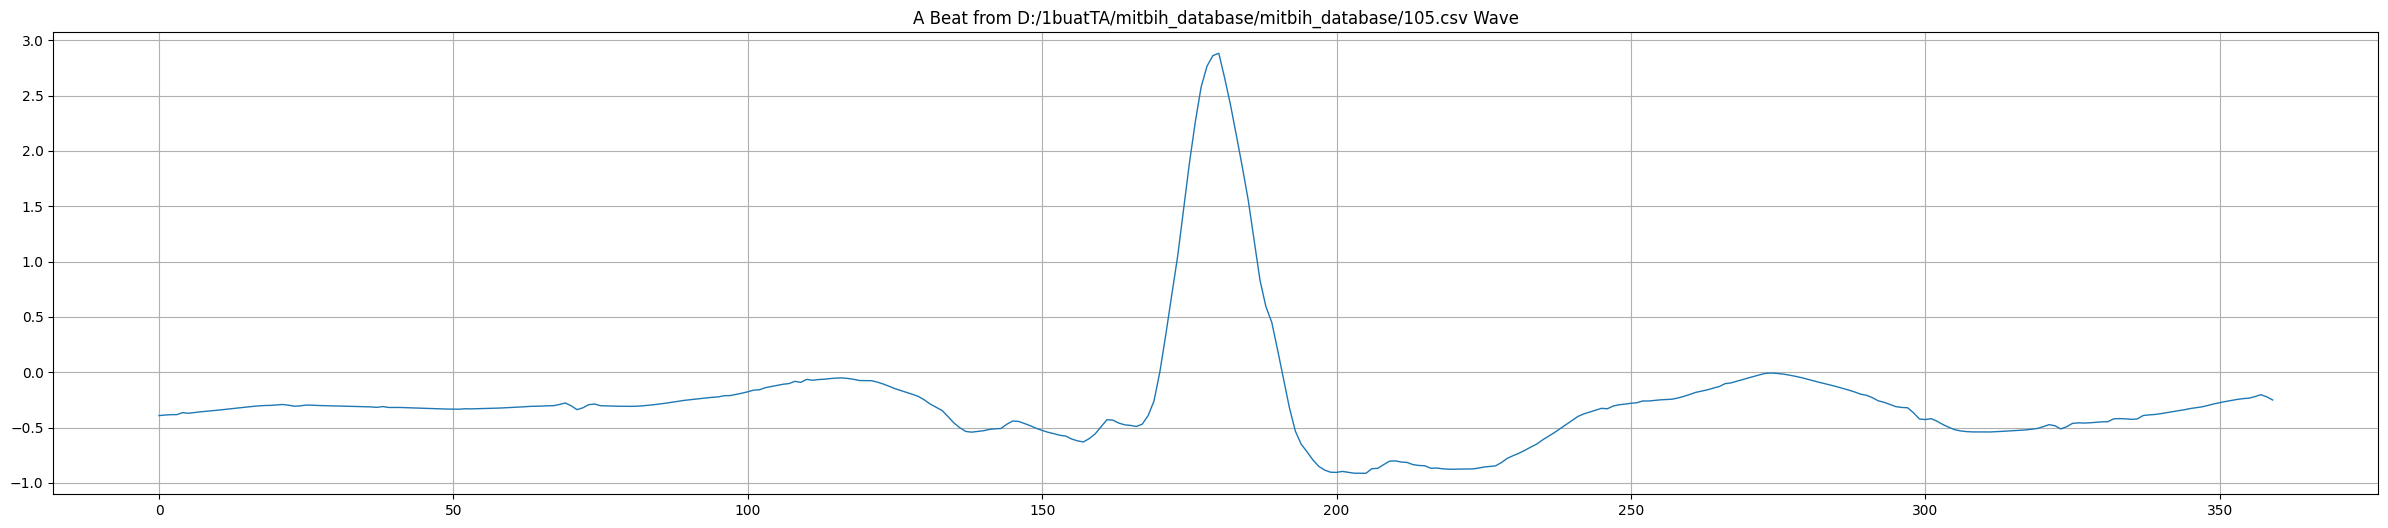

(100012, 360) (100012,)


In [8]:
# for each records
for r in range(0,len(records)):
    signals = []
    

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read ECG data from .csv
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
  #example plot of a sample 105.csv
    if r == 5:
        # Plot each patient's signal
        plt.title(records[5] + " Wave")
        plt.plot(signals[0:500])
        #plt.grid(False)
        plt.show()
        
    signals = denoise(signals) #denoising the signal
    # plotting after denoising
    if r == 5:
        plt.title(records[5] + " wave after denoised")
        plt.plot(signals[0:500])
        plt.show()
        
    signals = stats.zscore(signals) #performing Z score normalisation
    # Plot an example to the signals
    if r == 5:
        plt.title( records[5] + " wave after z-score normalization" )
        plt.plot(signals[0:500])
        plt.show()
    
    # Reading the R peaks and the annotation classes for each sample
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted))
            arrhythmia_type = next(splitted) # arrhythmia clas
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)

                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]  #R peaks  
                     
                    if r == 5 and not example_beat_printed: 
                        plt.title("A Beat from " + records[5] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))


In [9]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X)) #combining X and y to a single file

(100012, 361)


#Distribusi Kelas

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


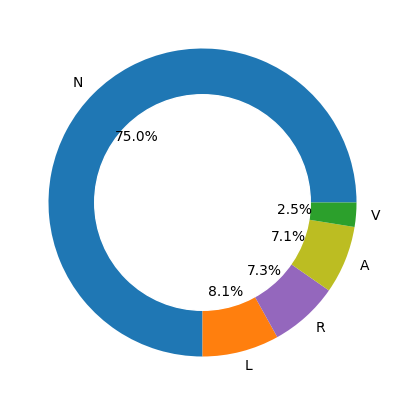

In [10]:
df = pd.DataFrame(X) #Array to df
per_class = df[df.shape[1]-1].value_counts() #class distribution
print(per_class)

#visualizing class distribution
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#Train-Test split

In [11]:
train,test=train_test_split(df,test_size=0.20) #train test split from the main dataframe
print("train : ", np.shape(train)) #train data shape
print("test  : ", np.shape(test)) #test data shape

train :  (80009, 361)
test  :  (20003, 361)


#Sampling Train Data

In [12]:
#down sampling class 0
df_0=(train[train[train.shape[1]-1]==0]).sample(7000,random_state=42)

#up sampling class 1
df_1=train[train[train.shape[1]-1]==1]
df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=23)

#up sampling class 2
df_2=train[train[train.shape[1]-1]==2]
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=23)

#up sampling class 3
df_3=train[train[train.shape[1]-1]==3]
df_3_upsample=resample(df_3,replace=True,n_samples=7000,random_state=23)

#up sampling class 4
df_4=train[train[train.shape[1]-1]==4]
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=23)


In [13]:
train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
#combining the sampled classes 

0.0    7000
1.0    7000
2.0    7000
3.0    7000
4.0    7000
Name: 360, dtype: int64


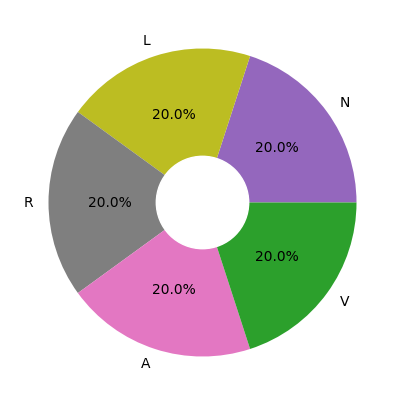

In [14]:
per_class = train_df[train_df.shape[1]-1].value_counts()
print(per_class)
#visualizing the sampled training data
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.3, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
#plt.title("Sampling in train data")
plt.show()

In [15]:
train_df.shape #sampled training data shape

(35000, 361)

In [16]:
per_class = train_df[train_df.shape[1]-1].value_counts()
per_class #checking the sampled train data class distribution


0.0    7000
1.0    7000
2.0    7000
3.0    7000
4.0    7000
Name: 360, dtype: int64

#Independent and Dependent variables in Test Data 

In [17]:
#test data #hided from the model till evaluation
test_x= test.iloc[:,:test.shape[1]-1].values
test_x=test_x.reshape(len(test_x), test_x.shape[1],1) #reshaping to fit deep learning models
test_y= test[test.shape[1]-1] 
test_y=to_categorical(test_y) #one hot encoding

In [18]:
print("test_x : ", np.shape(test_x)) #independent variables of test data
print("test_y  : ", np.shape(test_y)) #dependent variables of test data

test_x :  (20003, 360, 1)
test_y  :  (20003, 5)


In [19]:
per_class = test[test.shape[1]-1].value_counts()
print(per_class)
# plt.figure(figsize=(5,5))
# #visualize test data class distribution
# my_circle=plt.Circle( (0,0), 0.3, color='white')
# plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.title("No sampling in test data")
# plt.show()

0.0    15019
1.0     1626
2.0     1460
4.0     1423
3.0      475
Name: 360, dtype: int64


#Independent and dependent varibale in Training Data

In [21]:
target_train=train_df[train_df.shape[1]-1] #label train
# target_val=val[val.shape[1]-1] #labes test
train_y=to_categorical(target_train)
# val_y=to_categorical(target_val)
print(np.shape(train_y))

(35000, 5)


In [23]:
train_x = train_df.iloc[:,:train_df.shape[1]-1].values
# val_x = val.iloc[:,:val.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
# val_x = val_x.reshape(len(val_x), val_x.shape[1],1)
print(np.shape(train_x))

(35000, 360, 1)


In [24]:
print("train_x : ", np.shape(train_x)) #independent variables in test data
print("train_y  : ", np.shape(train_y)) #dependent variable in test data

train_x :  (35000, 360, 1)
train_y  :  (35000, 5)


# CNN Model

In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
import sklearn.metrics as metrics

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AvgPool1D, Flatten, Dropout, Dense, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def cnn_model():
    model = Sequential()
    #convolution layer 1
    model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
    model.add(AvgPool1D(pool_size=3, strides=2))
    #convoulution layer 2
    model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    #convolution layer 3
    model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    #convolution layer 4
    model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    #flattening layer 
    model.add(Flatten())
    #Droupout threshold 0.5
    model.add(Dropout(0.5))
    #outer dense layer with 5 neurons represent 5 classes
    model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Softmax()) #probability of the classes

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=hyperparameters['learning_rate']), metrics=['accuracy'])
    model.summary()

    return model

# Define your hyperparameters
hyperparameters = {
    'learning_rate': 0.001,
    'batch_size': 32,
    'num_epochs': 50,
    'dropout_rate': 0.5,
    'regularization_strength': 0.0001,
}

# Create the model with the defined hyperparameters
cnn = cnn_model()

# Now, you can train the model using the hyperparameters
history = cnn.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=hyperparameters['batch_size'], epochs=hyperparameters['num_epochs'])

# 32m 55.4s

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 360, 16)           224       
                                                                 
 average_pooling1d_12 (Avera  (None, 179, 16)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_13 (Conv1D)          (None, 179, 32)           7712      
                                                                 
 average_pooling1d_13 (Avera  (None, 89, 32)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_14 (Conv1D)          (None, 89, 64)            34880     
                                                                 
 average_pooling1d_14 (Avera  (None, 44, 64)          

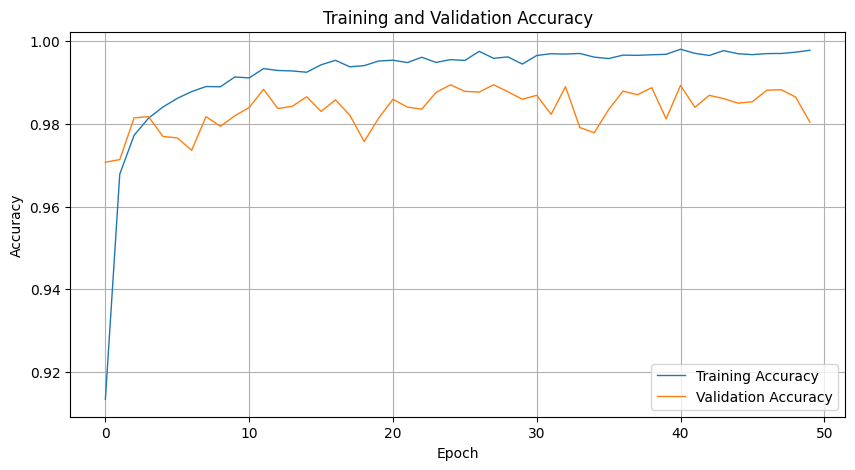

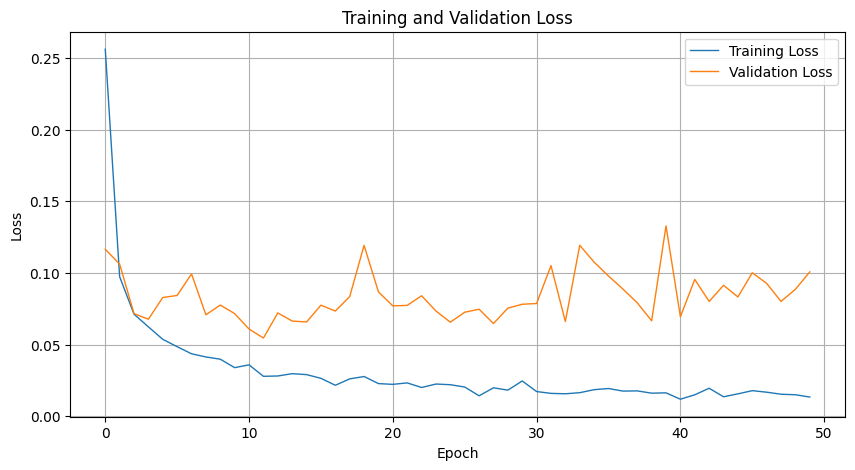

In [31]:
import matplotlib.pyplot as plt

# # Assuming you have defined your CNN model as 'cnn' and you are training it
# history = cnn.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=hyperparameters['batch_size'], epochs=hyperparameters['num_epochs'])

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


##CNN model plot

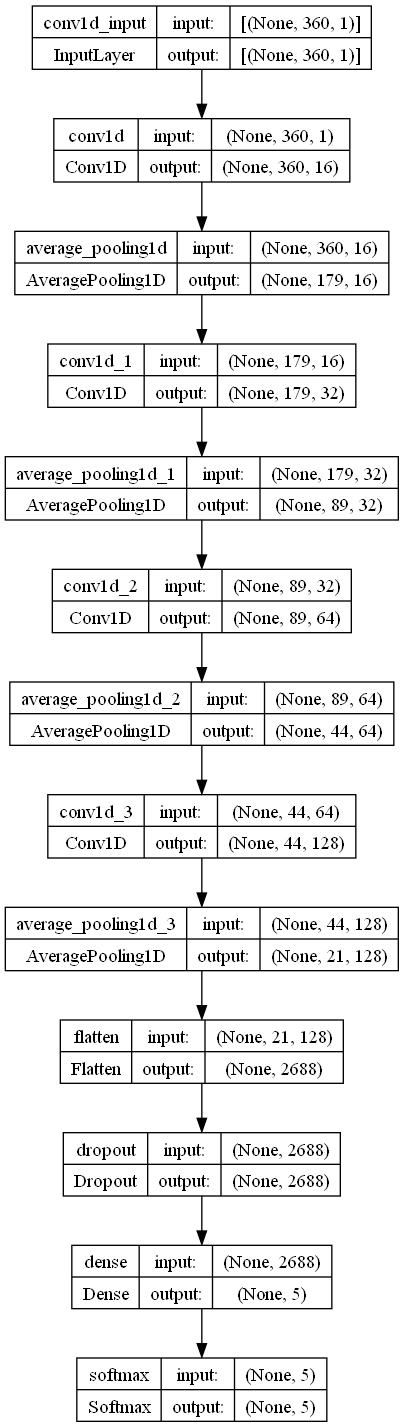

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# KFold cross validation CNN

Fold #1
219/219 [==============================] - 1s 6ms/step
Fold score (RMSE): 0.021876443177461624
Score for fold 1: loss of 0.007110266946256161; accuracy of 100.0%
Fold #2
219/219 [==============================] - 1s 6ms/step
Fold score (RMSE): 0.02338552474975586
Score for fold 2: loss of 0.0072255064733326435; accuracy of 100.0%
Fold #3
219/219 [==============================] - 1s 6ms/step
Fold score (RMSE): 0.034582316875457764
Score for fold 3: loss of 0.008247027173638344; accuracy of 100.0%
Fold #4
219/219 [==============================] - 1s 6ms/step
Fold score (RMSE): 0.019082507118582726
Score for fold 4: loss of 0.006688928231596947; accuracy of 100.0%
Fold #5
219/219 [==============================] - 1s 6ms/step
Fold score (RMSE): 0.010655300691723824
Score for fold 5: loss of 0.0060010673478245735; accuracy of 100.0%


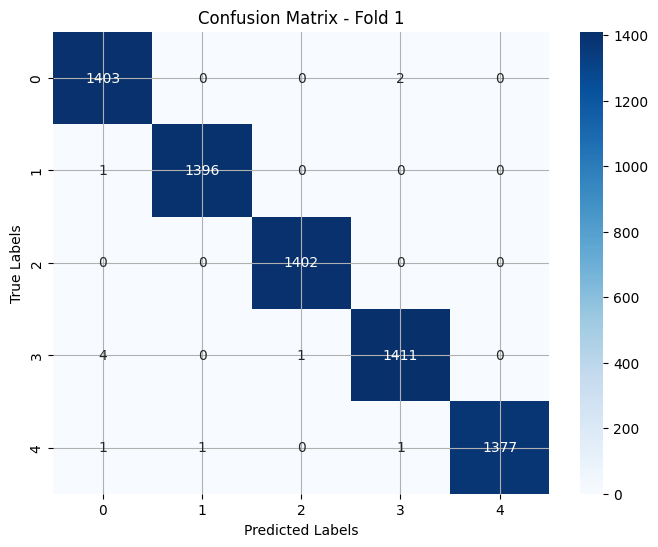

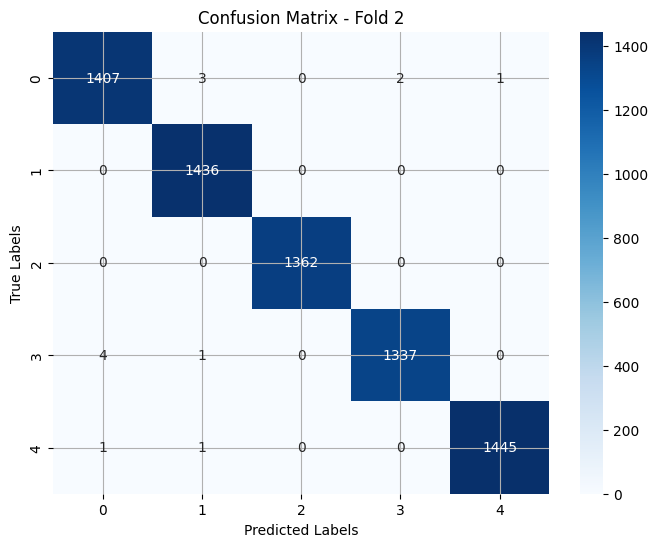

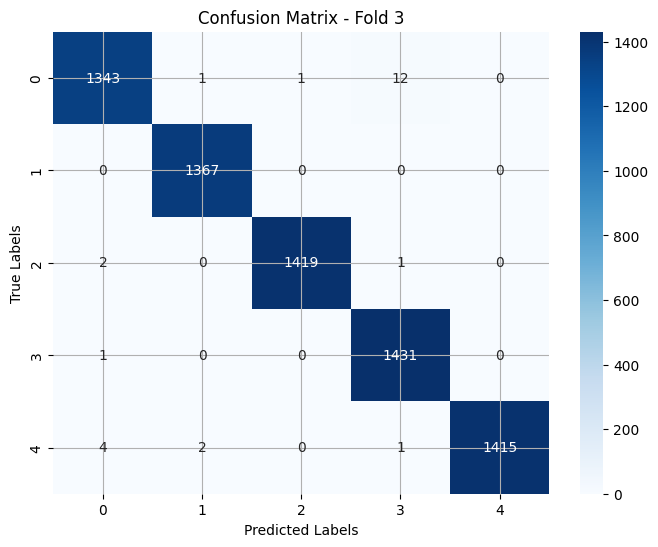

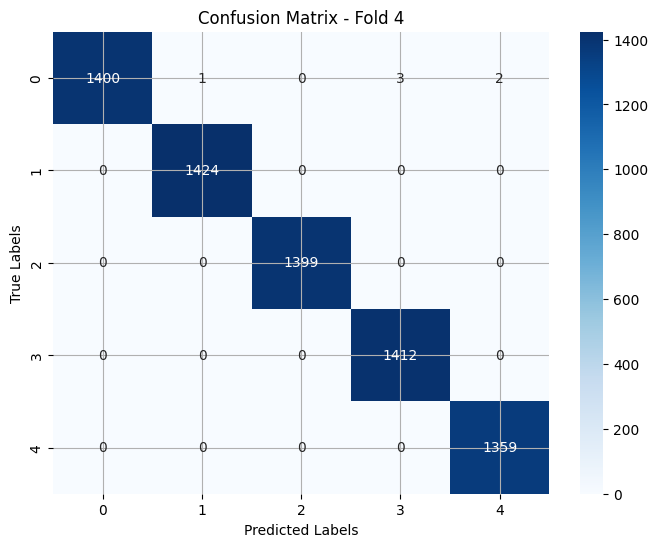

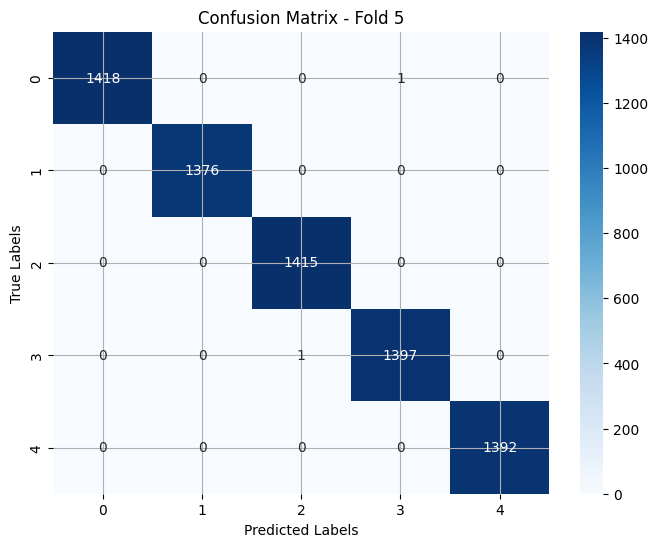

In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

kf = KFold(5, shuffle=True, random_state=42)
oos_y = []
oos_pred = []

acc_per_fold = []
loss_per_fold = []
rmse_per_fold = []
conf_matrices = []  # List to store confusion matrices
fold = 0

for train, test in kf.split(train_x, train_y):
    fold += 1
    print(f"Fold #{fold}")

    x_train = train_x[train]
    y_train = train_y[train]
    x_test = train_x[test]
    y_test = train_y[test]

    history = cnn.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=10)

    pred = cnn.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    conf_matrices.append(cm)
    
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    scores = cnn.evaluate(x_test, pred, verbose=0)
    print(f'Score for fold {fold}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

# Print confusion matrices
for fold, cm in enumerate(conf_matrices, start=1):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


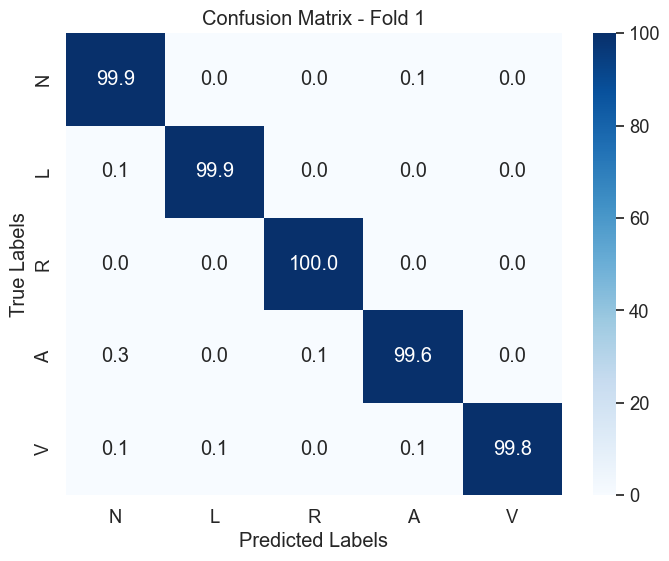

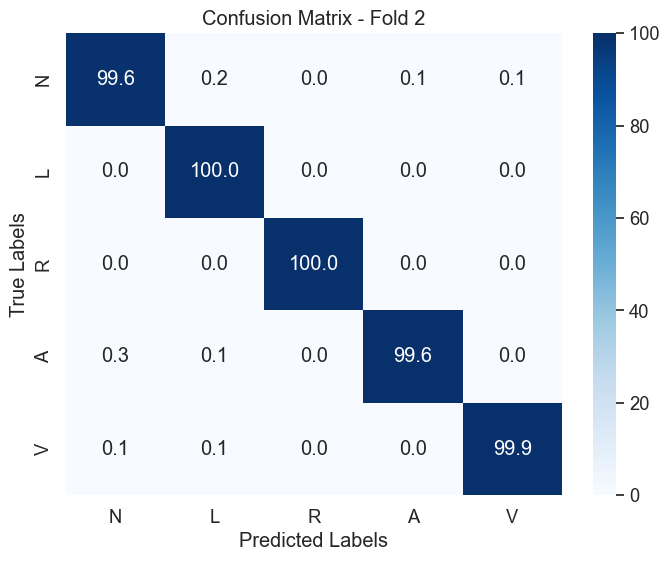

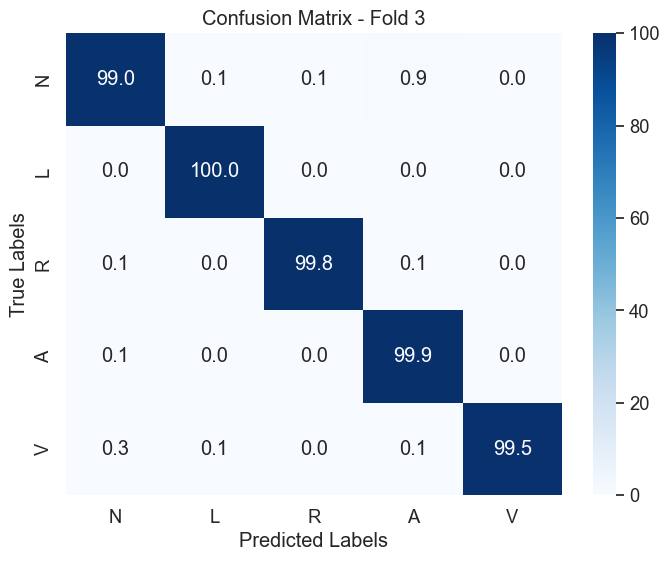

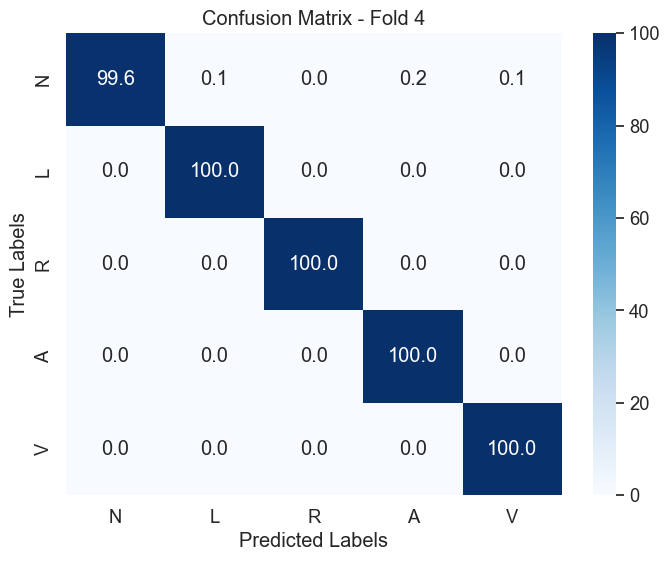

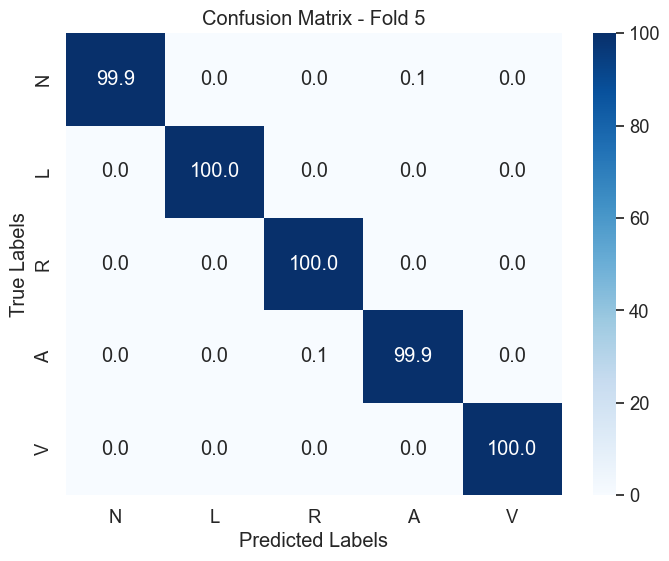

In [70]:
class_names = ['N', 'L', 'R', 'A', 'V']
for fold, cm in enumerate(conf_matrices, start=1):
    rowcnn = cm.sum(axis=1, keepdims=True)
    cmp = (cm/ rowcnn) * 100
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cmp, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    

In [178]:
conf_matrices

[array([[1403,    0,    0,    2,    0],
        [   1, 1396,    0,    0,    0],
        [   0,    0, 1402,    0,    0],
        [   4,    0,    1, 1411,    0],
        [   1,    1,    0,    1, 1377]], dtype=int64),
 array([[1407,    3,    0,    2,    1],
        [   0, 1436,    0,    0,    0],
        [   0,    0, 1362,    0,    0],
        [   4,    1,    0, 1337,    0],
        [   1,    1,    0,    0, 1445]], dtype=int64),
 array([[1343,    1,    1,   12,    0],
        [   0, 1367,    0,    0,    0],
        [   2,    0, 1419,    1,    0],
        [   1,    0,    0, 1431,    0],
        [   4,    2,    0,    1, 1415]], dtype=int64),
 array([[1400,    1,    0,    3,    2],
        [   0, 1424,    0,    0,    0],
        [   0,    0, 1399,    0,    0],
        [   0,    0,    0, 1412,    0],
        [   0,    0,    0,    0, 1359]], dtype=int64),
 array([[1418,    0,    0,    1,    0],
        [   0, 1376,    0,    0,    0],
        [   0,    0, 1415,    0,    0],
        [   0,    0,

In [40]:
average_acc=sum(acc_per_fold)/5 #to find average accuracy across 5 folds 
average_loss=sum(loss_per_fold)/5 #to find average loss across 5 folds
average_rmse=sum(rmse_per_fold)/5 # to find average rmse across 5 folds


## CNN Train Evaluation 

In [41]:
average_acc

100.0

In [42]:
average_loss

0.0070545592345297335

In [43]:
average_rmse

0.02191641852259636

In [52]:
import seaborn as sns
from sklearn.metrics import classification_report
plt.figure(figsize=(5,2)) 
y_true=[]
for element in train_y:
    y_true.append(np.argmax(element))
prediction_proba=cnn.predict(train_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction) 
print(classification_report(y_true, prediction, target_names=classes, digits=4))
custCnnConfMat = confusion_matrix(y_true, prediction)

1094/1094 [==============================] - 6s 6ms/step
              precision    recall  f1-score   support

           N     0.9993    0.9997    0.9995      7000
           L     1.0000    1.0000    1.0000      7000
           R     0.9984    1.0000    0.9992      7000
           A     0.9999    0.9971    0.9985      7000
           V     0.9993    1.0000    0.9996      7000

    accuracy                         0.9994     35000
   macro avg     0.9994    0.9994    0.9994     35000
weighted avg     0.9994    0.9994    0.9994     35000



<Figure size 500x200 with 0 Axes>

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in train_y:
    y_true.append(np.argmax(element))
prediction_proba=cnn.predict(train_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(model_cf_matrix[:, i]) - model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {specificity_per_class[i]:.4f}")


1094/1094 [==============================] - 6s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9993    0.9997    0.9995      7000
           L     1.0000    1.0000    1.0000      7000
           R     0.9984    1.0000    0.9992      7000
           A     0.9999    0.9971    0.9985      7000
           V     0.9993    1.0000    0.9996      7000

    accuracy                         0.9994     35000
   macro avg     0.9994    0.9994    0.9994     35000
weighted avg     0.9994    0.9994    0.9994     35000

Specificity for class N: 0.9998
Specificity for class L: 1.0000
Specificity for class R: 0.9996
Specificity for class A: 1.0000
Specificity for class V: 0.9998


1094/1094 [==============================] - 6s 5ms/step


<Axes: >

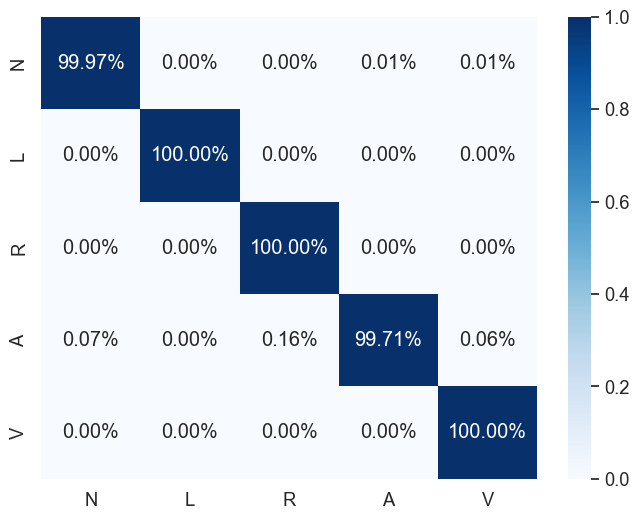

In [62]:
y_pred_cnn = cnn.predict(train_x)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_train_classes_cnn = np.argmax(train_y, axis=1)
cm_cnntrain = confusion_matrix(y_train_classes_cnn, y_pred_classes_cnn)
cm_ptrain = cm_cnntrain.astype('float') / cm_cnntrain.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_ptrain, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# print("Confusion Matrix:")
# print(cm_cnntrain)

In [82]:
TP_tcnn = cm_cnntrain[0][0]
FP_tcnn = cm_cnntrain[0][1]
FN_tcnn = cm_cnntrain[1][0]
TN_tcnn = cm_cnntrain[1][1]

accuracy_tcnn = (TP_tcnn+TN_tcnn) / (TP_tcnn+FP_tcnn+FN_tcnn+TN_tcnn)
specificity_tcnn = TN_tcnn / (TN_tcnn + FP_tcnn)
sensitivity_tcnn = TP_tcnn / (TP_tcnn + FN_tcnn)

print("Specificity:", specificity_tcnn)

Specificity: 1.0


## CNN Test Evaluation

### Test Loss and Accuracy

In [57]:
score = cnn.evaluate(test_x, test_y) #evaluating the models with the test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 4s 7ms/step - loss: 0.1135 - accuracy: 0.9887
Test Loss: 0.1135101243853569
Test accuracy: 0.9887017011642456


In [63]:
y_pred = cnn.predict(test_x, batch_size=1000) #predictions from the cnn model 

21/21 [==============================] - 3s 133ms/step


In [47]:
import seaborn as sns
from sklearn.metrics import classification_report
plt.figure(figsize=(5,2)) 
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=cnn.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction) 
print(classification_report(y_true, prediction, target_names=classes, digits=4))
custCnnConfMat = confusion_matrix(y_true, prediction)
# sns.heatmap(custCnnConfMat/np.sum(custCnnConfMat), annot=True,fmt='.3%', cmap='Blues')

626/626 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           N     0.9974    0.9886    0.9930     15019
           L     0.9957    0.9963    0.9960      1626
           R     0.9818    0.9979    0.9898      1460
           A     0.8293    0.9305    0.8770       475
           V     0.9572    0.9909    0.9738      1423

    accuracy                         0.9887     20003
   macro avg     0.9523    0.9809    0.9659     20003
weighted avg     0.9893    0.9887    0.9889     20003



<Figure size 500x200 with 0 Axes>

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=cnn.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(model_cf_matrix[:, i]) - model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {specificity_per_class[i]:.4f}")




626/626 [==============================] - 4s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9974    0.9886    0.9930     15019
           L     0.9957    0.9963    0.9960      1626
           R     0.9818    0.9979    0.9898      1460
           A     0.8293    0.9305    0.8770       475
           V     0.9572    0.9909    0.9738      1423

    accuracy                         0.9887     20003
   macro avg     0.9523    0.9809    0.9659     20003
weighted avg     0.9893    0.9887    0.9889     20003

Specificity for class N: 0.9924
Specificity for class L: 0.9996
Specificity for class R: 0.9985
Specificity for class A: 0.9953
Specificity for class V: 0.9966


In [53]:
y_pred_cnn = cnn.predict(test_x)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_test_classes_cnn = np.argmax(test_y, axis=1)
cm_cnn = confusion_matrix(y_test_classes_cnn, y_pred_classes_cnn)
print("Confusion Matrix:")
print(cm_cnn)

626/626 [==============================] - 4s 6ms/step
Confusion Matrix:
[[14848     7    20    87    57]
 [    2  1620     0     1     3]
 [    2     0  1457     0     1]
 [   25     0     6   442     2]
 [    9     0     1     3  1410]]


<Axes: >

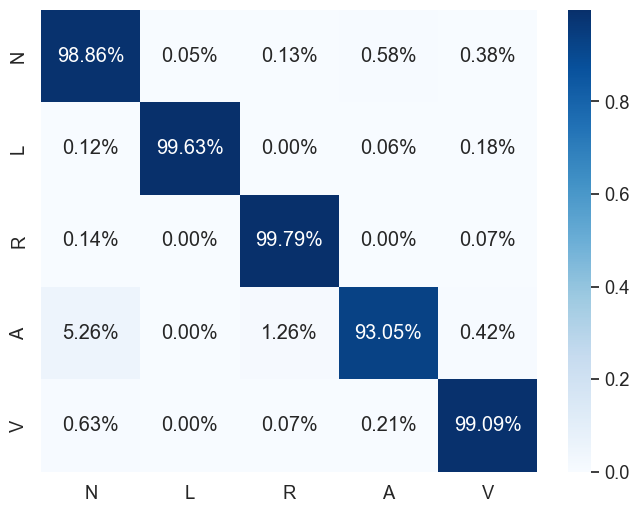

In [65]:
cm_ptest = cm_cnn.astype('float') / cm_cnn.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_ptest, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [77]:
TP_cnn = cm_cnn[0][0]
FP_cnn = cm_cnn[0][1]
FN_cnn = cm_cnn[1][0]
TN_cnn = cm_cnn[1][1]

accuracy_cnn = (TP_cnn+TN_cnn) / (TP_cnn+FP_cnn+FN_cnn+TN_cnn)
specificity_cnn = TN_cnn / (TN_cnn + FP_cnn)
sensitivity_cnn = TP_cnn / (TP_cnn + FN_cnn)

print("Specificity:", specificity_cnn)

Specificity: 0.9956976029502151


In [78]:
# Measure this RMSE
score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.332465667380862


# LSTM Model

In [83]:
def get_lstm():
    lstm_model = Sequential()
    #one layer of LSTM
    lstm_model.add(LSTM(64, input_shape=(360,1)))
    #Fully connected dense layer
    lstm_model.add(Dense(128, activation = 'relu'))
    #dropout threshold 0.3
    lstm_model.add(Dropout(0.3))
    #outer dense layer with 5 neurons
    lstm_model.add(Dense(5, activation = 'softmax'))
    
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    lstm_model.summary()
    return lstm_model

# Define your hyperparameters
hyperparameters = {
    'learning_rate': 0.001,
    'batch_size': 32,
    'num_epochs': 50,
    'dropout_rate': 0.5,
    'regularization_strength': 0.0001,
}

# Create the model with the defined hyperparameters
lstm=get_lstm()


history = lstm.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=hyperparameters['batch_size'], epochs=hyperparameters['num_epochs'])

# 120m 24.2s

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 25,861
Trainable params: 25,861
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1094/1094 [==============================] - 146s 131ms/step - loss: 1.3799 - accuracy: 0.4077 - val_loss: 1.2058 - val_accuracy: 0.5205
Epoch 2/50
1094/1094 [============

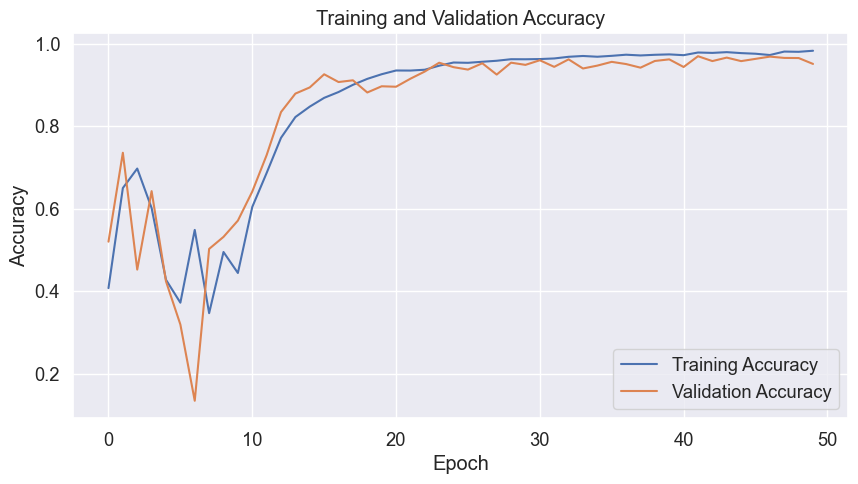

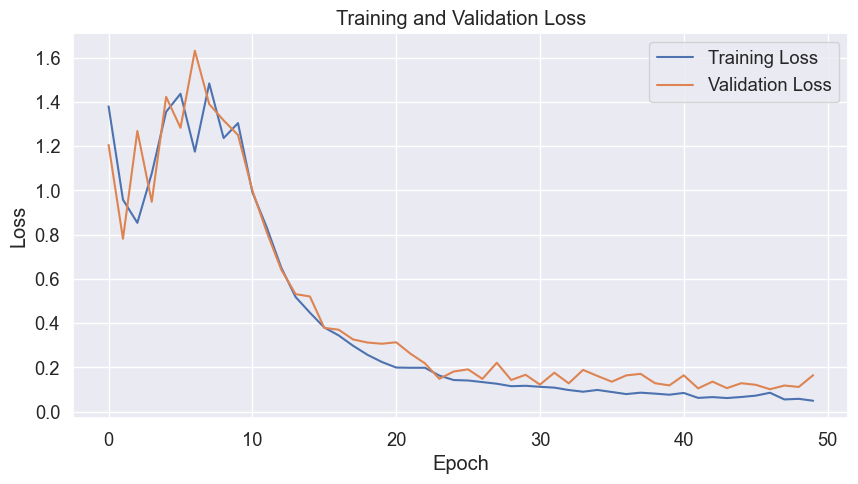

In [85]:
history = lstm.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=hyperparameters['batch_size'], epochs=hyperparameters['num_epochs'])
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#LSTM model plot

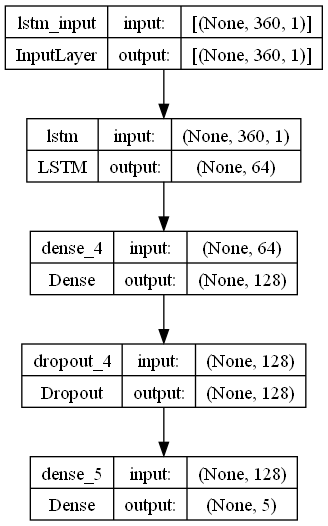

In [86]:
plot_model(lstm, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)

#KFold Cross Validation

In [87]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

kf = KFold(5, shuffle=True, random_state=42)
oos_y = []
oos_pred = []

lstm_acc_per_fold = []
lstm_loss_per_fold = []
lstm_rmse_per_fold = []
lstm_conf_matrices = []  # List to store confusion matrics
fold = 0

for train, test in kf.split(train_x, train_y):
    fold += 1
    print(f"Fold #{fold}")

    x_train = train_x[train]
    y_train = train_y[train]
    x_test = train_x[test]
    y_test = train_y[test]

    history = lstm.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=10)

    pred = lstm.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Compute the confusion matrix
    cm_lstm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    conf_matrices.append(cm_lstm)
    
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    lstm_rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    scores = lstm.evaluate(x_test, pred, verbose=0)
    print(f'Score for fold {fold}: {lstm.metrics_names[0]} of {scores[0]}; {lstm.metrics_names[1]} of {scores[1] * 100}%')
    lstm_acc_per_fold.append(scores[1] * 100)
    lstm_loss_per_fold.append(scores[0])

class_names = ['N', 'L', 'R', 'A', 'V']

for fold, cm_lstm in enumerate(lstm_conf_matrices, start=1):
    rowlstm = cm_lstm.sum(axis=1, keepdims=True)
    cmplstm = (cm_lstm/ rowlstm) * 100
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cmplstm, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


Fold #1
219/219 [==============================] - 10s 43ms/step
Fold score (RMSE): 0.09150253981351852
Score for fold 1: loss of 0.06178349256515503; accuracy of 100.0%
Fold #2
219/219 [==============================] - 9s 42ms/step
Fold score (RMSE): 0.05637528747320175
Score for fold 2: loss of 0.027857903391122818; accuracy of 100.0%
Fold #3
219/219 [==============================] - 9s 43ms/step
Fold score (RMSE): 0.06311842054128647
Score for fold 3: loss of 0.026025325059890747; accuracy of 100.0%
Fold #4
219/219 [==============================] - 10s 44ms/step
Fold score (RMSE): 0.052886076271533966
Score for fold 4: loss of 0.02187287248671055; accuracy of 100.0%
Fold #5
219/219 [==============================] - 9s 43ms/step
Fold score (RMSE): 0.049328263849020004
Score for fold 5: loss of 0.01771444082260132; accuracy of 100.0%


In [105]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

kf = KFold(5, shuffle=True, random_state=42)
oos_y = []
oos_pred = []

lstm_acc_per_fold = []
lstm_loss_per_fold = []
lstm_rmse_per_fold = []
lstm_conf_matrices = []  # List to store confusion matrics
fold = 0

for train, test in kf.split(train_x, train_y):
    fold += 1
    print(f"Fold #{fold}")

    x_train = train_x[train]
    y_train = train_y[train]
    x_test = train_x[test]
    y_test = train_y[test]

    history = lstm.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=10)

    pred = lstm.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Compute the confusion matrix
    cm_lstm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    lstm_conf_matrices.append(cm_lstm)
    # print(f"Confusion matrix for Fold #{fold}:\n{cm_lstm}")
    
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    lstm_rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    scores = lstm.evaluate(x_test, pred, verbose=0)
    print(f'Score for fold {fold}: {lstm.metrics_names[0]} of {scores[0]}; {lstm.metrics_names[1]} of {scores[1] * 100}%')
    lstm_acc_per_fold.append(scores[1] * 100)
    lstm_loss_per_fold.append(scores[0])
 

Fold #1
219/219 [==============================] - 10s 44ms/step
Fold score (RMSE): 0.03409557417035103
Score for fold 1: loss of 0.006705078296363354; accuracy of 100.0%
Fold #2
219/219 [==============================] - 10s 44ms/step
Fold score (RMSE): 0.032321497797966
Score for fold 2: loss of 0.007255628239363432; accuracy of 100.0%
Fold #3
219/219 [==============================] - 10s 43ms/step
Fold score (RMSE): 0.040568310767412186
Score for fold 3: loss of 0.011493169702589512; accuracy of 100.0%
Fold #4
219/219 [==============================] - 12s 54ms/step
Fold score (RMSE): 0.02705642208456993
Score for fold 4: loss of 0.009715713560581207; accuracy of 100.0%
Fold #5
219/219 [==============================] - 10s 43ms/step
Fold score (RMSE): 0.03117537312209606
Score for fold 5: loss of 0.0037490518298000097; accuracy of 100.0%


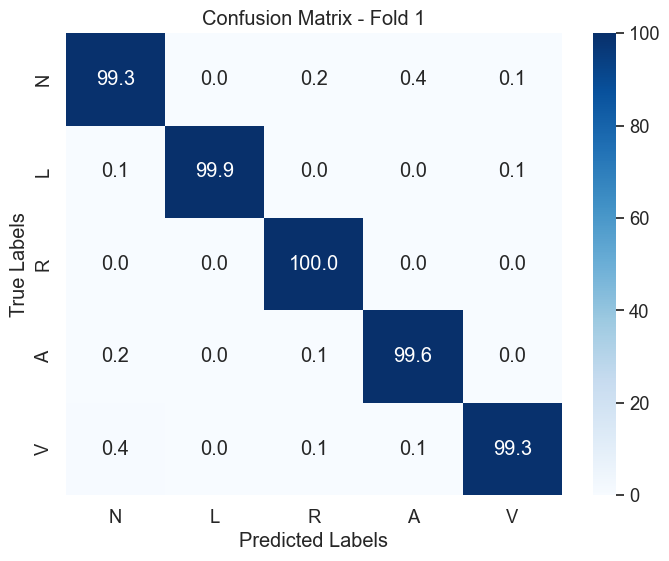

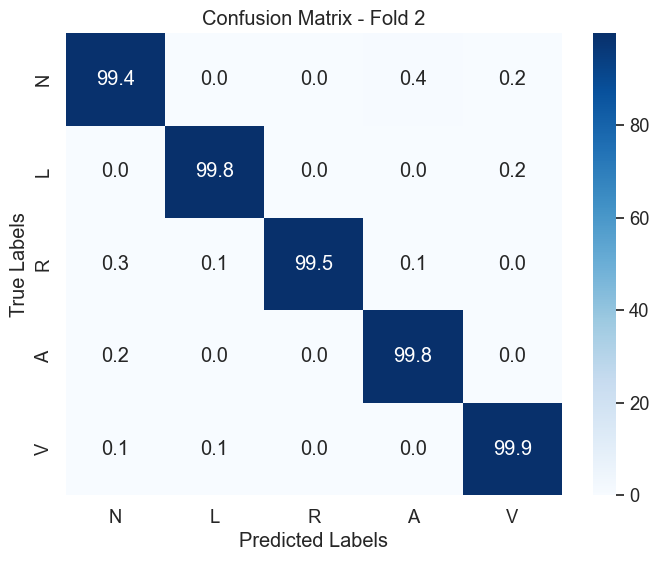

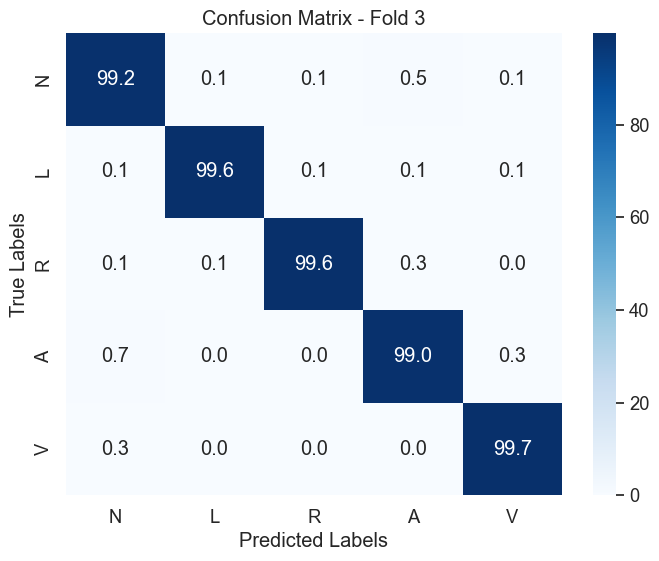

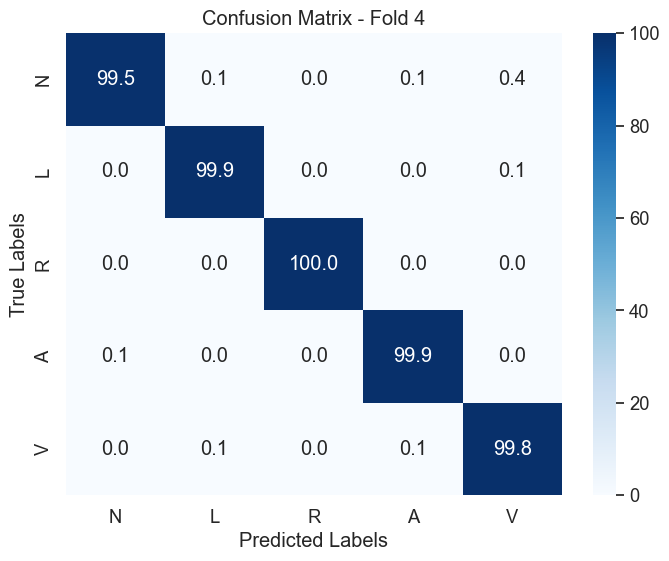

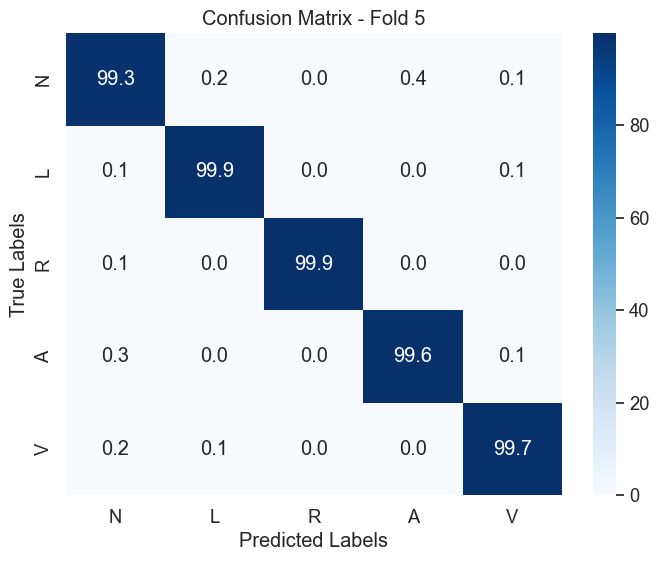

In [106]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['N', 'L', 'R', 'A', 'V']

for fold, cm_lstm in enumerate(lstm_conf_matrices, start=1):
    rowlstm = cm_lstm.sum(axis=1, keepdims=True)
    cmplstm = (cm_lstm/ rowlstm) * 100
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cmplstm, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [177]:
lstm_conf_matrices

[array([[1395,    0,    3,    5,    2],
        [   1, 1395,    0,    0,    1],
        [   0,    0, 1402,    0,    0],
        [   3,    0,    2, 1411,    0],
        [   6,    0,    1,    2, 1371]], dtype=int64),
 array([[1404,    0,    0,    6,    3],
        [   0, 1433,    0,    0,    3],
        [   4,    1, 1355,    2,    0],
        [   3,    0,    0, 1339,    0],
        [   1,    1,    0,    0, 1445]], dtype=int64),
 array([[1346,    2,    1,    7,    1],
        [   1, 1361,    2,    1,    2],
        [   1,    1, 1416,    4,    0],
        [  10,    0,    0, 1418,    4],
        [   4,    0,    0,    0, 1418]], dtype=int64),
 array([[1399,    1,    0,    1,    5],
        [   0, 1423,    0,    0,    1],
        [   0,    0, 1399,    0,    0],
        [   1,    0,    0, 1411,    0],
        [   0,    1,    0,    2, 1356]], dtype=int64),
 array([[1409,    3,    0,    5,    2],
        [   1, 1374,    0,    0,    1],
        [   1,    0, 1414,    0,    0],
        [   4,    0,

# LSTM Training Evaluation

In [129]:
lstm_average_acc=sum(acc_per_fold)/5 #average of LSTM accuracy across 5 fold
lstm_average_loss=sum(loss_per_fold)/5 #average of LSTM loss across 5 fold
lstm_average_rmse=sum(rmse_per_fold)/5 #average of LSTM rmse across 5 fold

In [130]:
lstm_average_acc

100.0

In [131]:
lstm_average_loss

0.0070545592345297335

In [132]:
lstm_average_rmse

0.02191641852259636

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in train_y:
    y_true.append(np.argmax(element))
prediction_proba=lstm.predict(train_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
lstm_model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
lstm_specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(lstm_model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(lstm_model_cf_matrix[:, i]) - lstm_model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    lstm_specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {lstm_specificity_per_class[i]:.4f}")


1094/1094 [==============================] - 47s 43ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9969    0.9979    0.9974      7000
           L     0.9987    0.9997    0.9992      7000
           R     0.9997    0.9994    0.9996      7000
           A     0.9989    0.9977    0.9983      7000
           V     0.9990    0.9984    0.9987      7000

    accuracy                         0.9986     35000
   macro avg     0.9986    0.9986    0.9986     35000
weighted avg     0.9986    0.9986    0.9986     35000

Specificity for class N: 0.9992
Specificity for class L: 0.9997
Specificity for class R: 0.9999
Specificity for class A: 0.9997
Specificity for class V: 0.9998


1094/1094 [==============================] - 49s 44ms/step


<Axes: >

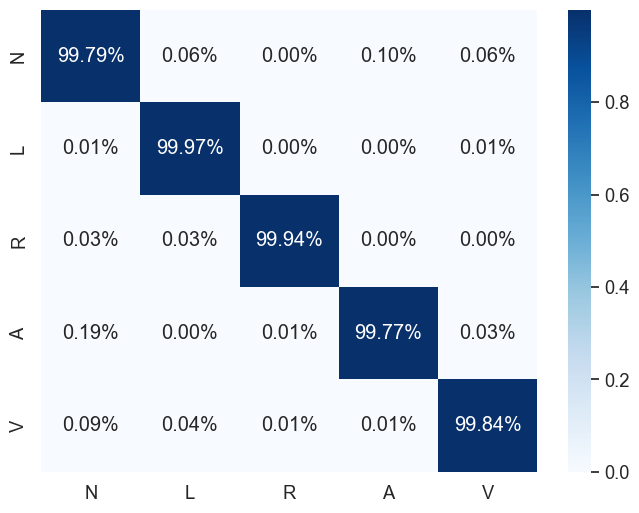

In [141]:
y_pred_lstm = lstm.predict(train_x)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_train_classes_lstm = np.argmax(train_y, axis=1)
cm_lstmtrain = confusion_matrix(y_train_classes_lstm, y_pred_classes_lstm)
cm_lstmptrain = cm_lstmtrain.astype('float') / cm_lstmtrain.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_lstmptrain, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [143]:
TP_tlstm = cm_lstmtrain[0][0]
FP_tlstm = cm_lstmtrain[0][1]
FN_tlstm = cm_lstmtrain[1][0]
TN_tlstm = cm_lstmtrain[1][1]

accuracy_tlstm = (TP_tlstm+TN_tlstm) / (TP_tlstm+FP_tlstm+FN_tlstm+TN_tlstm)
specificity_tlstm = TN_tlstm / (TN_tlstm + FP_tlstm)
sensitivity_tlstm = TP_tlstm / (TP_tlstm + FN_tlstm)

print("Specificity:", specificity_tcnn)

Specificity: 1.0


## LSTM Test Evaluation

### Test Loss and Accuracy

In [134]:
score = lstm.evaluate(test_x, test_y) #evaluation of LSTM on test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 28s 44ms/step - loss: 0.1382 - accuracy: 0.9794
Test Loss: 0.13824966549873352
Test accuracy: 0.9794030785560608


In [135]:
y_pred = lstm.predict(test_x, batch_size=1000) #prediction by the LSTM model

21/21 [==============================] - 11s 521ms/step


In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=lstm.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(model_cf_matrix[:, i]) - model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {specificity_per_class[i]:.4f}")


626/626 [==============================] - 28s 45ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9957    0.9794    0.9874     15019
           L     0.9710    0.9889    0.9799      1626
           R     0.9830    0.9904    0.9867      1460
           A     0.7052    0.9116    0.7952       475
           V     0.9369    0.9803    0.9581      1423

    accuracy                         0.9794     20003
   macro avg     0.9184    0.9701    0.9415     20003
weighted avg     0.9817    0.9794    0.9801     20003

Specificity for class N: 0.9872
Specificity for class L: 0.9974
Specificity for class R: 0.9987
Specificity for class A: 0.9907
Specificity for class V: 0.9949


In [148]:
y_pred_lstm = lstm.predict(test_x)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_test_classes_lstm = np.argmax(test_y, axis=1)
cm_lstm = confusion_matrix(y_test_classes_lstm, y_pred_classes_lstm)
print("Confusion Matrix:")
print(cm_lstm)

626/626 [==============================] - 28s 45ms/step
Confusion Matrix:
[[14709    45    20   163    82]
 [    8  1608     0     3     7]
 [    8     0  1446     6     0]
 [   32     0     5   433     5]
 [   16     3     0     9  1395]]


<Axes: >

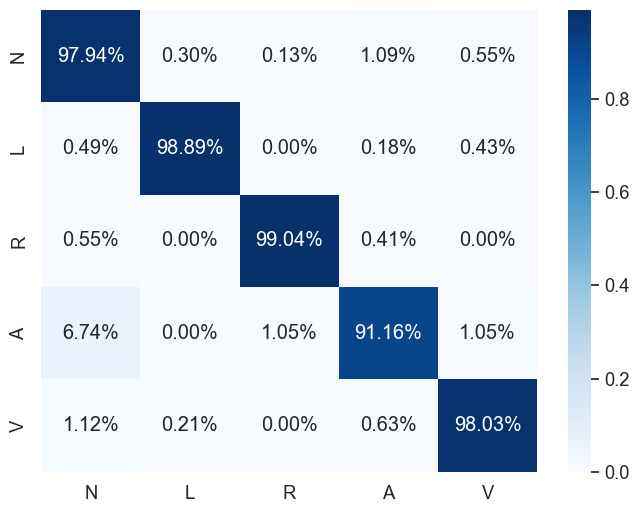

In [152]:
cm_lstmptest = cm_lstm.astype('float') / cm_lstm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_lstmptest, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [150]:
TP_lstm = cm_lstm[0][0]
FP_lstm = cm_lstm[0][1]
FN_lstm = cm_lstm[1][0]
TN_lstm = cm_lstm[1][1]

specificity_lstm = TN_lstm / (TN_lstm + FP_lstm)

print("Specificity:", specificity_lstm)

Specificity: 0.9727767695099818


In [ ]:
# TP_lstm = cm_lstm[0][0]
# FP_lstm = cm_lstm[0][1]
# FN_lstm = cm_lstm[1][0]
# TN_lstm = cm_lstm[1][1]

# accuracy_lstm = (TP_lstm+TN_lstm) / (TP_lstm+FP_lstm+FN_lstm+TN_lstm)
# specificity_lstm = TN_lstm / (TN_lstm + FP_lstm)
# sensitivity_lstm = TP_lstm / (TP_lstm + FN_lstm)

# # print("Accuracy:", accuracy_lstm)
# print("Specificity:", specificity_lstm)
# # print("Sensitivity:", sensitivity_lstm)

In [151]:

score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.4251151509488518


# GRU Model

In [153]:
def get_gru():
    gru_model = Sequential()
    #single layer GRU
    gru_model.add(GRU(64, input_shape=(360,1)))
    #fully connected outer layer
    gru_model.add(Dense(128, activation = 'relu'))
    #droput threshold 0.3
    gru_model.add(Dropout(0.3))
    #outer layer with 5 neurons
    gru_model.add(Dense(5, activation = 'softmax'))
    
    gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

# Define your hyperparameters
hyperparameters = {
    'learning_rate': 0.001,
    'batch_size': 32,
    'num_epochs': 50,
    'dropout_rate': 0.5,
    'regularization_strength': 0.0001,
}

# Create the model with the defined hyperparameters
gru=get_gru()


history = gru.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=hyperparameters['batch_size'], epochs=hyperparameters['num_epochs'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 21,829
Trainable params: 21,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1094/1094 [==============================] - 137s 122ms/step - loss: 1.5489 - accuracy: 0.3086 - val_loss: 1.5901 - val_accuracy: 0.1163
Epoch 2/50
1094/1094 [============

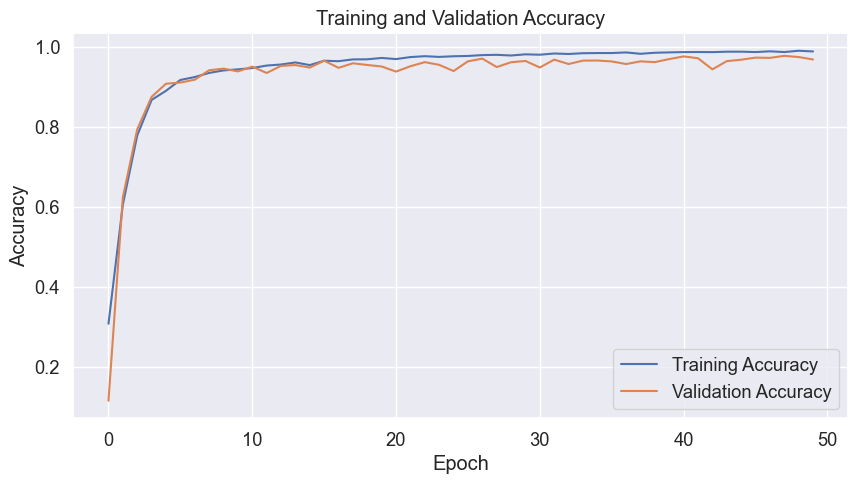

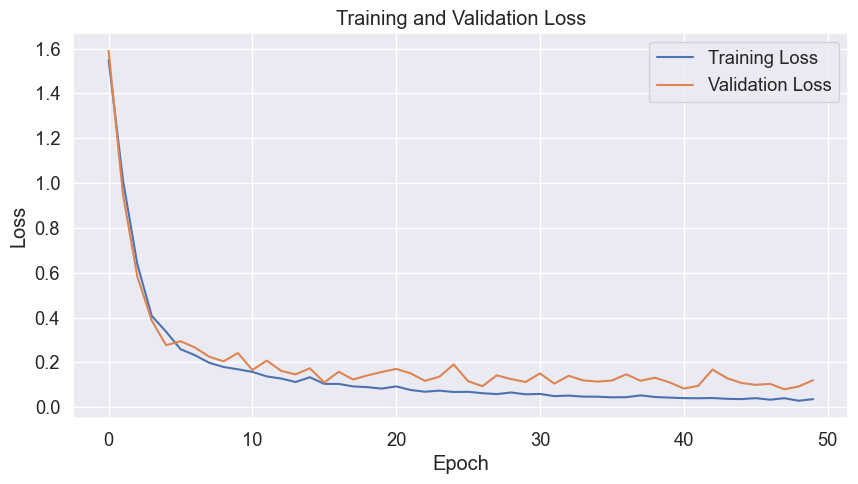

In [155]:
import matplotlib.pyplot as plt

history = gru.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=hyperparameters['batch_size'], epochs=hyperparameters['num_epochs'])

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


##GRU Model Plot

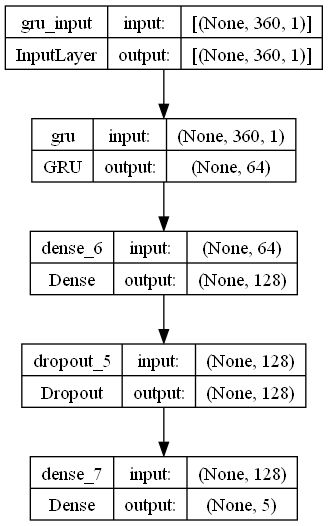

In [156]:
plot_model(gru, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## KFold cross Validation

Fold #1
219/219 [==============================] - 7s 31ms/step
Fold score (RMSE): 0.05435121804475784
Score for fold 1: loss of 0.01776442676782608; accuracy of 100.0%
Fold #2
219/219 [==============================] - 7s 32ms/step
Fold score (RMSE): 0.04731651768088341
Score for fold 2: loss of 0.019705533981323242; accuracy of 100.0%
Fold #3
219/219 [==============================] - 7s 31ms/step
Fold score (RMSE): 0.05162816122174263
Score for fold 3: loss of 0.015652045607566833; accuracy of 100.0%
Fold #4
219/219 [==============================] - 7s 33ms/step
Fold score (RMSE): 0.0512714646756649
Score for fold 4: loss of 0.01833908073604107; accuracy of 100.0%
Fold #5
219/219 [==============================] - 7s 33ms/step
Fold score (RMSE): 0.060212355107069016
Score for fold 5: loss of 0.02798124961555004; accuracy of 100.0%


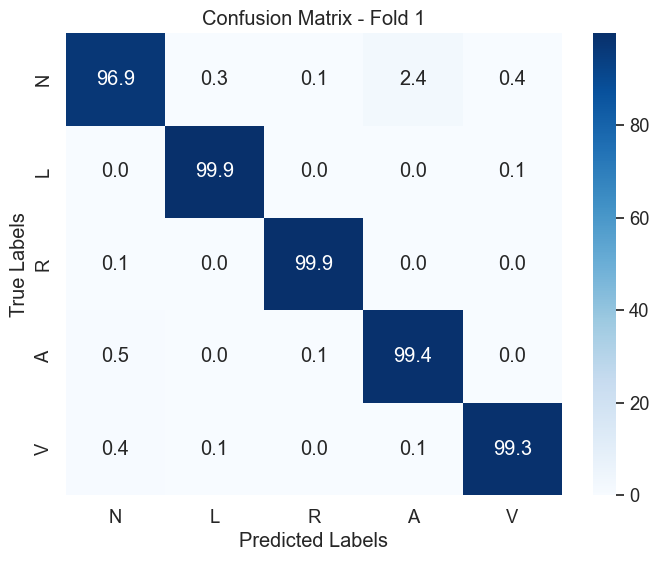

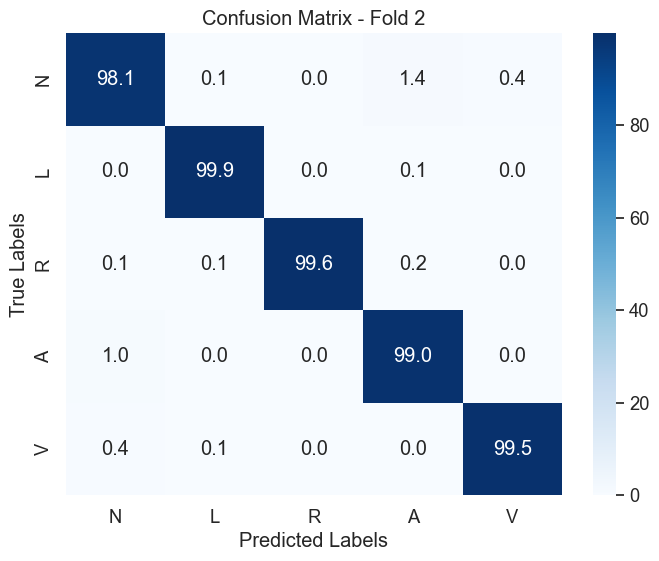

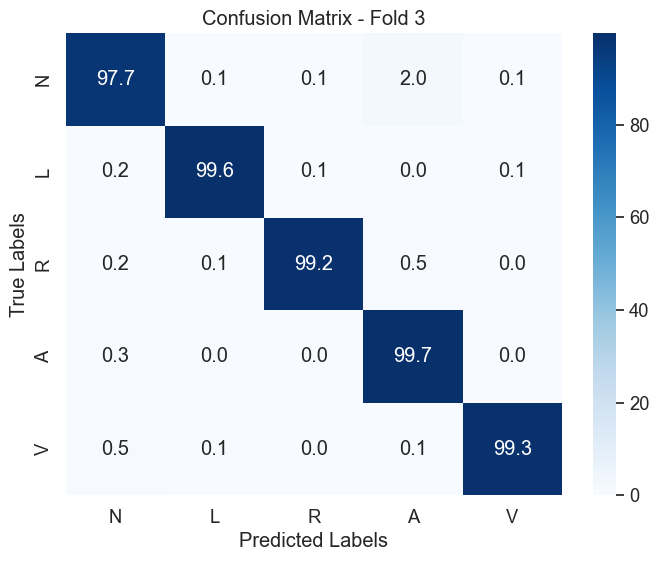

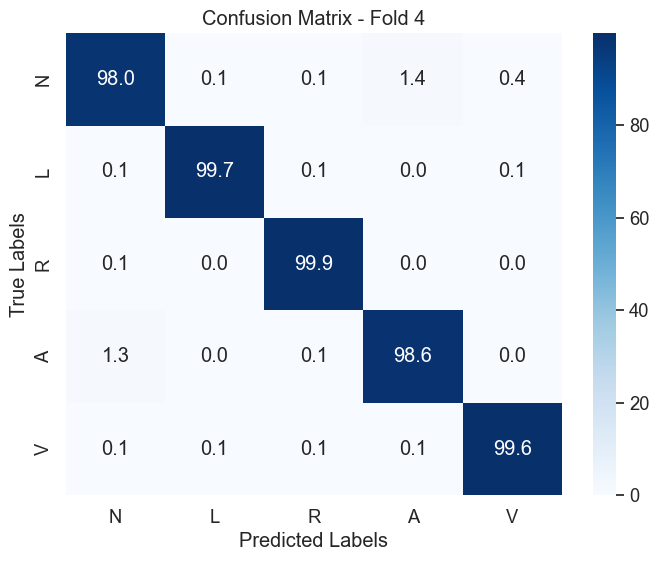

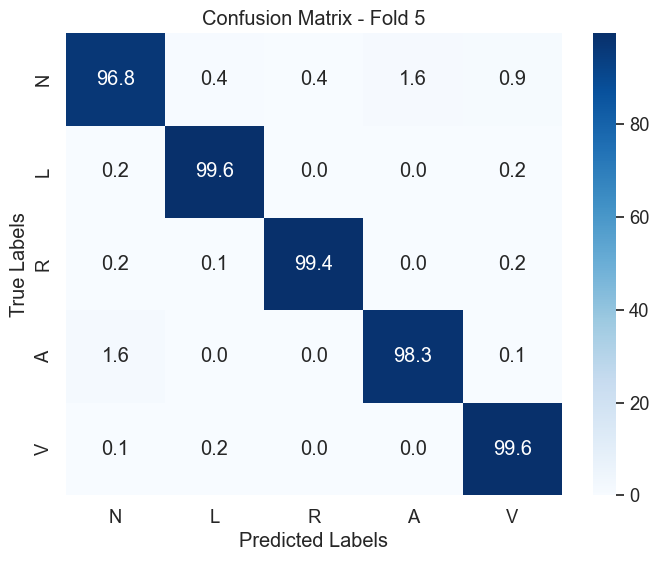

In [158]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

kf = KFold(5, shuffle=True, random_state=42)
oos_y = []
oos_pred = []

gru_acc_per_fold = []
gru_loss_per_fold = []
gru_rmse_per_fold = []
gru_conf_matrices = []  # List to store confusion matrics
fold = 0

for train, test in kf.split(train_x, train_y):
    fold += 1
    print(f"Fold #{fold}")

    x_train = train_x[train]
    y_train = train_y[train]
    x_test = train_x[test]
    y_test = train_y[test]

    history = gru.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=10)

    pred = gru.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Compute the confusion matrix
    cm_gru = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    gru_conf_matrices.append(cm_gru)
    # print(f"Confusion matrix for Fold #{fold}:\n{cm_gru}")
    
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    gru_rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    scores = gru.evaluate(x_test, pred, verbose=0)
    print(f'Score for fold {fold}: {gru.metrics_names[0]} of {scores[0]}; {gru.metrics_names[1]} of {scores[1] * 100}%')
    gru_acc_per_fold.append(scores[1] * 100)
    gru_loss_per_fold.append(scores[0])

class_names = ['N', 'L', 'R', 'A', 'V']

for fold, cm_gru in enumerate(gru_conf_matrices, start=1):
    rowgru = cm_gru.sum(axis=1, keepdims=True)
    cmpgru = (cm_gru/ rowgru) * 100
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cmpgru, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
 

In [159]:
gru_conf_matrices

[array([[1361,    4,    1,   34,    5],
        [   0, 1395,    0,    0,    2],
        [   2,    0, 1400,    0,    0],
        [   7,    0,    2, 1407,    0],
        [   6,    2,    0,    2, 1370]], dtype=int64),
 array([[1386,    1,    0,   20,    6],
        [   0, 1435,    0,    1,    0],
        [   1,    1, 1357,    3,    0],
        [  13,    0,    0, 1329,    0],
        [   6,    1,    0,    0, 1440]], dtype=int64),
 array([[1326,    1,    1,   27,    2],
        [   3, 1362,    1,    0,    1],
        [   3,    1, 1411,    7,    0],
        [   4,    0,    0, 1428,    0],
        [   7,    2,    0,    1, 1412]], dtype=int64),
 array([[1378,    1,    2,   20,    5],
        [   2, 1420,    1,    0,    1],
        [   1,    0, 1398,    0,    0],
        [  19,    0,    1, 1392,    0],
        [   1,    1,    2,    2, 1353]], dtype=int64),
 array([[1373,    6,    5,   22,   13],
        [   3, 1370,    0,    0,    3],
        [   3,    2, 1407,    0,    3],
        [  22,    0,

## GRU Training Evaluation

In [161]:
gru_average_acc=sum(gru_acc_per_fold)/5 #GRU Average Accuracy
gru_average_loss=sum(gru_loss_per_fold)/5 #GRU average Loss
gru_average_rmse=sum(gru_rmse_per_fold)/5 #GRU average rmse

In [162]:
gru_average_acc

100.0

In [163]:
gru_average_loss

0.019888467341661453

In [164]:
gru_average_rmse

0.05295594334602356

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in train_y:
    y_true.append(np.argmax(element))
prediction_proba=gru.predict(train_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
gru_model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
gru_specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(gru_model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(gru_model_cf_matrix[:, i]) - gru_model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    gru_specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {gru_specificity_per_class[i]:.4f}")


1094/1094 [==============================] - 37s 34ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9833    0.9764    0.9799      7000
           L     0.9956    0.9970    0.9963      7000
           R     0.9964    0.9933    0.9948      7000
           A     0.9859    0.9869    0.9864      7000
           V     0.9897    0.9973    0.9935      7000

    accuracy                         0.9902     35000
   macro avg     0.9902    0.9902    0.9902     35000
weighted avg     0.9902    0.9902    0.9902     35000

Specificity for class N: 0.9959
Specificity for class L: 0.9989
Specificity for class R: 0.9991
Specificity for class A: 0.9965
Specificity for class V: 0.9974


1094/1094 [==============================] - 39s 36ms/step


<Axes: >

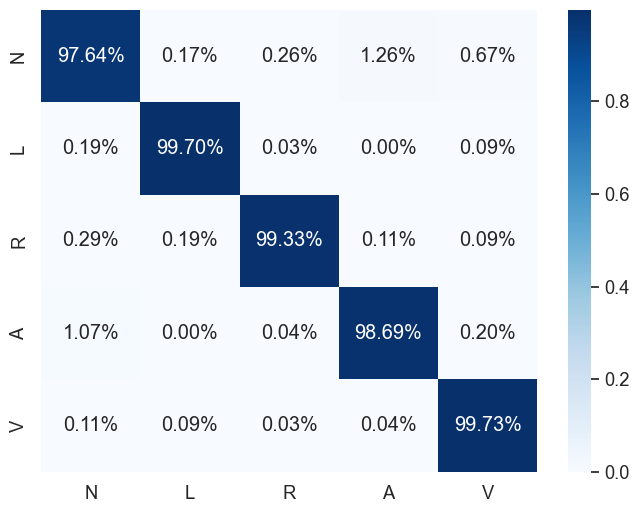

In [167]:
y_pred_gru = gru.predict(train_x)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
y_train_classes_gru = np.argmax(train_y, axis=1)
cm_grutrain = confusion_matrix(y_train_classes_gru, y_pred_classes_gru)
cm_gruptrain = cm_grutrain.astype('float') / cm_grutrain.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_gruptrain, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [168]:
TP_tgru = cm_grutrain[0][0]
FP_tgru = cm_grutrain[0][1]
FN_tgru = cm_grutrain[1][0]
TN_tgru = cm_grutrain[1][1]

accuracy_tgru = (TP_tgru+TN_tgru) / (TP_tgru+FP_tgru+FN_tgru+TN_tgru)
specificity_tgru = TN_tgru / (TN_tgru + FP_tgru)
sensitivity_tgru = TP_tgru / (TP_tgru + FN_tgru)

print("Specificity:", specificity_tcnn)

Specificity: 1.0


## GRU Test Evaluation

In [170]:
score = gru.evaluate(test_x, test_y) #Evaluation of GRU in test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 24s 39ms/step - loss: 0.1373 - accuracy: 0.9607
Test Loss: 0.13725002110004425
Test accuracy: 0.9607058763504028


In [171]:
y_pred = gru.predict(test_x, batch_size=1000) #GRU model prediction

21/21 [==============================] - 6s 271ms/step


###Test Data confusion matrix

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=gru.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(model_cf_matrix[:, i]) - model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {specificity_per_class[i]:.4f}")


626/626 [==============================] - 21s 33ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9958    0.9550    0.9750     15019
           L     0.9554    0.9877    0.9713      1626
           R     0.9599    0.9829    0.9712      1460
           A     0.5308    0.9263    0.6748       475
           V     0.8739    0.9789    0.9234      1423

    accuracy                         0.9607     20003
   macro avg     0.8631    0.9662    0.9031     20003
weighted avg     0.9702    0.9607    0.9636     20003

Specificity for class N: 0.9878
Specificity for class L: 0.9959
Specificity for class R: 0.9968
Specificity for class A: 0.9801
Specificity for class V: 0.9892


In [173]:
y_pred_gru = gru.predict(test_x)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
y_test_classes_gru = np.argmax(test_y, axis=1)
cm_gru = confusion_matrix(y_test_classes_gru, y_pred_classes_gru)
print("Confusion Matrix:")
print(cm_gru)

626/626 [==============================] - 20s 33ms/step
Confusion Matrix:
[[14343    64    55   372   185]
 [   10  1606     0     3     7]
 [   11     3  1435     7     4]
 [   27     0     3   440     5]
 [   13     8     2     7  1393]]


<Axes: >

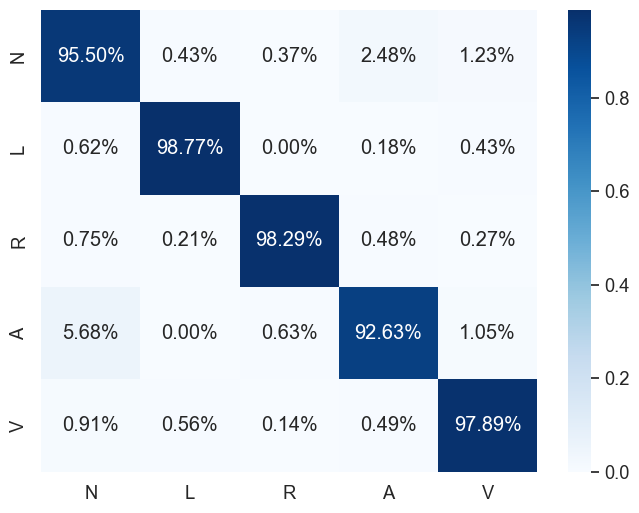

In [176]:
cm_gruptest = cm_gru.astype('float') / cm_gru.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_gruptest, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [174]:
TP_gru = cm_gru[0][0]
FP_gru = cm_gru[0][1]
FN_gru = cm_gru[1][0]
TN_gru = cm_gru[1][1]

specificity_gru = TN_gru / (TN_gru + FP_gru)

print("Specificity:", specificity_gru)

Specificity: 0.9616766467065868


In [175]:
#RMSE of GRU
score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.6038172825477874
